In [103]:
# For data manipulation
import numpy as np
import pandas as pd
import scipy.signal as signal

# For visualizing the data
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
sns.set_style('darkgrid')

# For data preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize


import sys
sys.path.append('../Librerias')
import dataset as ds
#no sé porqué no funciona cuando lo tengo en la carpeta de clusters
#pero si funciona cuando esta solo en la de notebooks,,, raro.

In [28]:
#load data

fpath = "/Users/granosftp/Documents/GitHub/Tesis/data/"
fname = "datosconsu_021023_bajos.mat"
cutoff = [8/1000, 11/1000]

set =  ds.MatFileToDataFrame(fpath, fname)
df = set.get_dataframe(cutoff)
df.tail()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform
599995,5.210999,-0.843661,0.008744,0.008744-0.033806j
599996,5.063692,-0.990968,0.008370,0.008370-0.038726j
599997,5.012726,-1.041933,0.007971,0.007971-0.026995j
599998,4.868050,-1.186610,0.007550,0.007550-0.033919j
599999,4.806563,-1.248097,0.007108,0.007108+0.008805j


In [29]:
amplitude_env = np.abs(df['Hilbert Transform'])
inst_phase =  np.unwrap(np.angle(df['Hilbert Transform']))
inst_freq = (np.diff(inst_phase)/(2.0*np.pi)*1000)
diff_phase =  np.diff(inst_phase)
mean_phase = np.mean(diff_phase)
diff_phase = np.insert(diff_phase, 0, 0)  

In [30]:
df['Amplitude Envelope'] = amplitude_env
df['Instantaneous Phase'] = inst_phase

#filtro al gradiente de fase

cutoff = 0.1
order = 4

b,a = signal.butter(order, cutoff, btype='low')
grad_phase = signal.filtfilt(b, a, diff_phase-mean_phase)

df['Gradient Phase'] = grad_phase

In [31]:
df.head()

,Original Signal,Signal - Mean,Filtered Signal,Hilbert Transform,Amplitude Envelope,Instantaneous Phase,Gradient Phase
0,5.326740,-0.727920,-0.071002,-0.071002-0.004745j,0.071160,-3.074865,-0.059617
1,5.335618,-0.719042,-0.060395,-0.060395-0.067391j,0.090494,-2.301505,-0.032723
2,5.460895,-0.593765,-0.049986,-0.049986-0.073204j,0.088642,-2.169909,-0.007483
3,5.491145,-0.563515,-0.039782,-0.039782-0.095259j,0.103232,-1.966397,0.014630
4,5.615436,-0.439224,-0.029789,-0.029789-0.098247j,0.102663,-1.865189,0.032492


In [32]:
start_end_defectos = [
    [25014, 25042],
    [27460, 27487],
    [35630, 35658],
    [37207, 37236],
    [48343, 48372],
    [57421, 57450],
    [61722, 61750],
    [78988, 79016],
    [82306, 82336],
    [84344, 84373],
    [97845, 97875], #10
    [99883, 99914], 
    [101083, 101111],
    [131884, 131912],
    [165590, 165619],
    [166234, 166264],
    [183081, 183109],
    [187677, 187705],
    [203502, 203530],
    [219482, 219510],
    [235509, 235537], #20
    [275603, 275633],
    [277908, 277936],
    [301722, 301753],
    [322041, 322070],
    [322422, 322450],
    [339137, 339166],
    [393906, 393935],
    [395396, 395424],
    [396716, 396746],
    [412940, 412969], #30
    [413358, 413386], 
    [430261, 430289],
    [444404, 444433],
    [453962, 453990],
    [456065, 456095],
    [456863, 456892],
    [457187, 457215],
    [457390, 457419],
    [470756, 470783],
    [474540, 474568], #40
    [502372, 502400],
    [564199, 564227]
]

### **Ventanas**

Por EDA se obtiene una posible escala para la división de la ventana de tiempo. Esta corresponde entre 10.000 y 13.500 pts por ventana.
Por lo mismo, las ventanas se harán de 10.000pts con un overlap de 1.500 pts por lado.

In [75]:
window_size = 6000
overlap = 500

num_windows = (len(df) - window_size) // (window_size - overlap) + 1

windows = []
for i in range(num_windows):
    start = i * (window_size - overlap)
    end = start + window_size
    window = df.iloc[start:end]
    windows.append(window)

In [76]:
def find_windows(start_end_defectos, windows):
    result = []
    for start, end in start_end_defectos:
        for i, window in enumerate(windows):
            if start >= window.index[0] and end <= window.index[-1]:
                result.append(i)
                break
    return result

window_indices = find_windows(start_end_defectos, windows)


### **frames for training**

In [84]:
wframe = []
for window in windows:
    a = window['Gradient Phase'].values
    b = window['Amplitude Envelope'].values
    c = np.concatenate((a, b), axis=0)
    wframe.append(c)

wframe = pd.DataFrame(wframe)

In [90]:
unique_indices = np.unique(window_indices)
wframe['label'] = np.where(wframe.index.isin(unique_indices), 1, 0)
wframe_no_labels = wframe.drop('label', axis=1)


### **SVM**

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Split the dataframe into 70% training and 30% testing subsets
train_df, test_df = train_test_split(wframe, test_size=0.3, random_state=42)

# Create an instance of SVC
svm = SVC()

# Fit the model to the training data
svm.fit(train_df.drop('label', axis=1), train_df['label'])

# Predict the labels for the testing data
predictions = svm.predict(test_df.drop('label', axis=1))

# Print the shapes of the subsets
print("Training subset shape:", train_df.shape)
print("Testing subset shape:", test_df.shape)

Training subset shape: (76, 12001)
Testing subset shape: (33, 12001)
[0 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0]


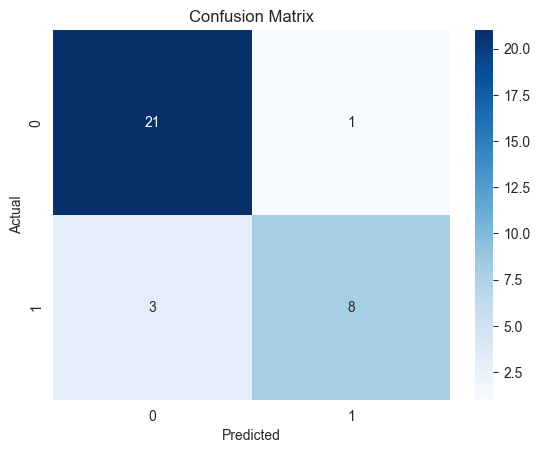

              precision    recall  f1-score   support

           0       0.88      0.95      0.91        22
           1       0.89      0.73      0.80        11

    accuracy                           0.88        33
   macro avg       0.88      0.84      0.86        33
weighted avg       0.88      0.88      0.88        33



In [96]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(test_df['label'], predictions)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print the classification report
report = classification_report(test_df['label'], predictions)
print(report)


In [97]:
wrong_indices = test_df.index[test_df['label'] != predictions]
print(wrong_indices)

Index([78, 30, 79, 72], dtype='int64')


In [107]:
for ind in wrong_indices:
    subset = windows[ind]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=subset.index, y=subset['Amplitude Envelope'], name='Amplitude Envelope'))
    fig.add_trace(go.Scatter(x=subset.index, y=subset['Gradient Phase'], name='Gradient Phase'))
    fig.add_trace(go.Scatter(x=subset.index, y=subset['Filtered Signal'], name='Signal'))
    fig.update_layout(title='Index: ' + str(ind))
    fig.show()
    

En general, algoritmo se equivoca en zonas con 2 o más defectos.